In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scaper_waspaa2017.urban_sed import eval as E
from scaper_waspaa2017.urban_sed_crnn import eval as ECR
from imp import reload
import glob
import os
import pandas as pd
import scaper
import jams
import numpy as np
from tqdm import tqdm

## First run on all files to ensure consistent results

In [2]:
reload(E)
feature_folder_test = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/features/logmelspec1764_128/test/'
file_list = sorted(glob.glob(os.path.join(feature_folder_test, '*.npy.gz')))
file_list = [os.path.basename(x).replace('.npy.gz', '') for x in file_list]

In [92]:
len(file_list)

2000

In [2]:
results001_all = E.evaluate_file_list('exp001', file_list, load_predictions=True, large_cnn=False)

F1s: 0.5688, P1s: 0.6911, R1s: 0.4833, F100ms: 0.5688, P100ms: 0.6911, R100ms: 0.4833 | E1s: 0.5770, E100ms: 0.5770


In [5]:
results002_all = ECR.evaluate_file_list('exp002', file_list, load_predictions=True)

F1s: 0.4957, P1s: 0.4410, R1s: 0.5660, F100ms: 0.4785, P100ms: 0.4438, R100ms: 0.5191 | E1s: 0.8769, E100ms: 0.8520


In [4]:
results003_all = E.evaluate_file_list('exp003', file_list, load_predictions=True, large_cnn=True)

F1s: 0.5778, P1s: 0.6720, R1s: 0.5069, F100ms: 0.5778, P100ms: 0.6720, R100ms: 0.5069 | E1s: 0.5595, E100ms: 0.5595


## Run eval_per_file to see how it compares

In [3]:
results001_perfile = E.evaluate_per_file('exp001', file_list, load_predictions=True, large_cnn=False)

F1s: 0.5688, P1s: 0.6911, R1s: 0.4833, F100ms: 0.5688, P100ms: 0.6911, R100ms: 0.4833 | E1s: 0.5770, E100ms: 0.5770


In [6]:
results002_perfile = ECR.evaluate_per_file('exp002', file_list, load_predictions=True)

F1s: 0.4953, P1s: 0.4397, R1s: 0.5670, F100ms: 0.4781, P100ms: 0.4418, R100ms: 0.5208 | E1s: 0.8872, E100ms: 0.8572


In [5]:
results003_perfile = E.evaluate_per_file('exp003', file_list, load_predictions=True, large_cnn=True)

F1s: 0.5778, P1s: 0.6720, R1s: 0.5069, F100ms: 0.5778, P100ms: 0.6720, R100ms: 0.5069 | E1s: 0.5595, E100ms: 0.5595


conclusion: the per_file eval and file_list eval produce sufficiently similar results such that they can be used interchangeably :)

## Get some stats on test set

In [84]:
vals_maxpoly = []
vals_nevents = []
vals_gini = []
vals_avg_snr = []
vals_fg_events = ({'event_duration': [],
                  'event_time': [],
                  'label': [],
                  'pitch_shift': [],
                  'snr': [],
                  'time_stretch': []})

event_properties = ['event_duration', 'event_time', 'label', 'pitch_shift', 'snr', 'time_stretch']

for filename in tqdm(file_list):

    jamfile = os.path.join(metafolder, filename + '.jams')
    jam = jams.load(jamfile)
                 
    vals_maxpoly.append(jam.annotations[0].sandbox['scaper']['polyphony_max'])
    vals_nevents.append(jam.annotations[0].sandbox['scaper']['n_events'])
    vals_gini.append(jam.annotations[0].sandbox['scaper']['polyphony_gini'])
    
    snrs = []
    for event in jam.annotations[0].data['value']:
        if event['role'] == 'foreground':
            for prop in event_properties:
                vals_fg_events[prop].append(event[prop])
                
            snrs.append(event['snr'])
    vals_avg_snr.append(np.mean(snrs))

100%|██████████| 2000/2000 [00:38<00:00, 51.86it/s]


### distribution of n_events

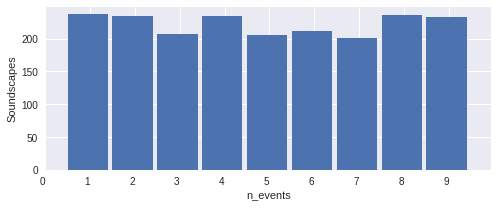

(array([ 237.,  234.,  207.,  234.,  206.,  212.,  201.,  236.,  233.]), array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]), <a list of 9 Patch objects>)


In [85]:
fig = plt.figure(figsize=(8, 3))
counts = plt.hist(vals_nevents, bins=np.arange(0, 10)+0.5, width=0.9)
plt.xticks(range(10), ha='right')
plt.ylabel('Soundscapes')
plt.xlabel('n_events')
plt.show()
print(counts)

In [87]:
# How many events total?
len(vals_fg_events['label'])

9956

In [91]:
# How many events of each class?
df_label = pd.DataFrame(vals_fg_events['label'])
df_label[0].value_counts()

car_horn            1033
drilling            1025
dog_bark            1016
children_playing     999
engine_idling        998
siren                998
gun_shot             995
street_music         977
air_conditioner      964
jackhammer           951
Name: 0, dtype: int64

### distirbution of max poly

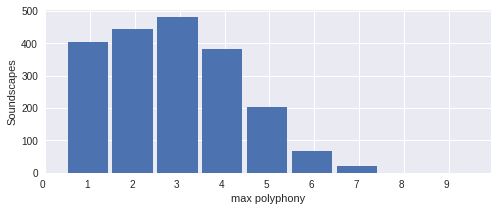

(array([ 402.,  445.,  479.,  382.,  204.,   67.,   21.,    0.,    0.]), array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]), <a list of 9 Patch objects>)


In [80]:
fig = plt.figure(figsize=(8, 3))
counts = plt.hist(vals_maxpoly, bins=np.arange(0, 10)+0.5, width=0.9)
plt.xticks(range(10), ha='right')
plt.ylabel('Soundscapes')
plt.xlabel('max polyphony')
plt.show()
print(counts)

### distribution of gini

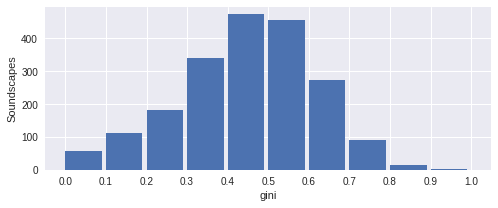

(array([  58.,  113.,  183.,  339.,  473.,  455.,  272.,   92.,   14.,    1.]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]), <a list of 10 Patch objects>)


In [81]:
fig = plt.figure(figsize=(8, 3))
counts = plt.hist(vals_gini, bins=np.arange(0, 1.1, 0.1), width=0.09)
plt.xticks(np.arange(0, 1.1, 0.1), ha='center')
plt.ylabel('Soundscapes')
plt.xlabel('gini')
plt.show()
print(counts)

### distribution of avg snr

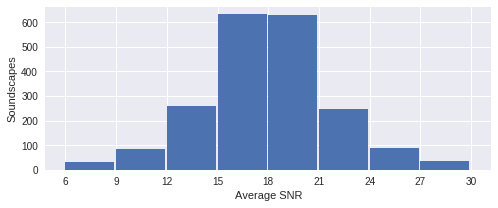

(array([  31.,   83.,  258.,  631.,  629.,  246.,   87.,   35.]), array([ 6,  9, 12, 15, 18, 21, 24, 27, 30]), <a list of 8 Patch objects>)


In [82]:
fig = plt.figure(figsize=(8, 3))
counts = plt.hist(vals_avg_snr, bins=np.arange(6, 31, 3), width=2.9)
plt.xticks(np.arange(6, 31, 3), ha='center')
plt.ylabel('Soundscapes')
plt.xlabel('Average SNR')
plt.show()
print(counts)

### distribution of event properties

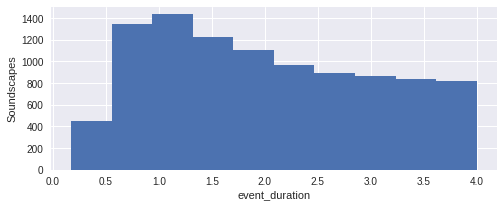

(array([  447.,  1343.,  1434.,  1230.,  1110.,   970.,   897.,   864.,
         840.,   821.]), array([ 0.17      ,  0.5529958 ,  0.93599161,  1.31898741,  1.70198322,
        2.08497902,  2.46797482,  2.85097063,  3.23396643,  3.61696224,
        3.99995804]), <a list of 10 Patch objects>)


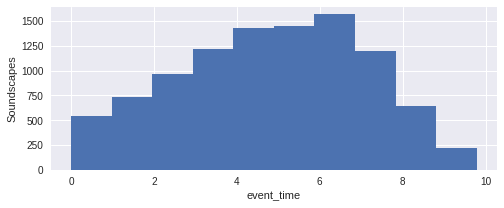

(array([  545.,   733.,   961.,  1213.,  1427.,  1451.,  1565.,  1194.,
         647.,   220.]), array([  9.76967818e-04,   9.79467106e-01,   1.95795724e+00,
         2.93644738e+00,   3.91493752e+00,   4.89342766e+00,
         5.87191780e+00,   6.85040793e+00,   7.82889807e+00,
         8.80738821e+00,   9.78587835e+00]), <a list of 10 Patch objects>)


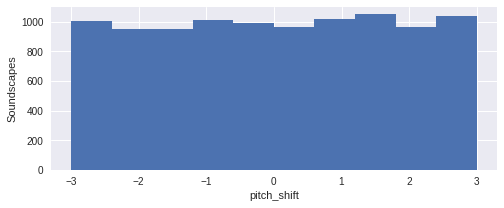

(array([ 1007.,   954.,   951.,  1010.,   994.,   966.,  1021.,  1049.,
         965.,  1039.]), array([ -2.99875374e+00,  -2.39893342e+00,  -1.79911310e+00,
        -1.19929278e+00,  -5.99472461e-01,   3.47859939e-04,
         6.00168181e-01,   1.19998850e+00,   1.79980882e+00,
         2.39962914e+00,   2.99944946e+00]), <a list of 10 Patch objects>)


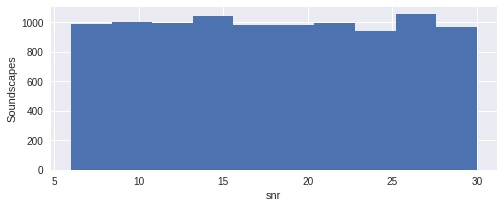

(array([  987.,  1001.,   995.,  1042.,   986.,   982.,   999.,   944.,
        1054.,   966.]), array([  6.00062362,   8.39999264,  10.79936166,  13.19873068,
        15.5980997 ,  17.99746873,  20.39683775,  22.79620677,
        25.19557579,  27.59494481,  29.99431383]), <a list of 10 Patch objects>)


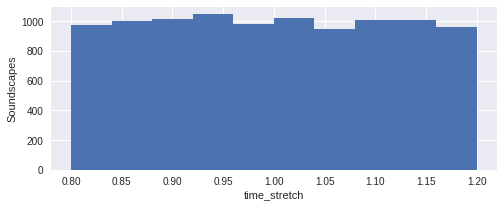

(array([  973.,  1001.,  1011.,  1044.,   982.,  1023.,   949.,  1009.,
        1005.,   959.]), array([ 0.80001954,  0.84001237,  0.88000519,  0.91999801,  0.95999083,
        0.99998365,  1.03997648,  1.0799693 ,  1.11996212,  1.15995494,
        1.19994777]), <a list of 10 Patch objects>)


In [83]:
for prop in event_properties:
    
    if prop != 'label':
        fig = plt.figure(figsize=(8, 3))
        counts = plt.hist(vals_fg_events[prop])
    #     plt.xticks(np.arange(0, 1.1, 0.1), ha='center')
        plt.ylabel('Soundscapes')
        plt.xlabel(prop)
        plt.show()
        print(counts)

## Generate file lists for all conditions

In [78]:
metafolder = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/metadata/test/'

file_list_bymaxpoly = [[] for _ in range(9)]
file_list_bynevents = [[] for _ in range(9)]
file_list_bygini = [[] for _ in range(10)]
file_list_byavgsnr = [[] for _ in range(8)]
file_list_byavgsnr_half = [[] for _ in range(4)]

# Get file lists    
for filename in tqdm(file_list):

    jamfile = os.path.join(metafolder, filename + '.jams')
    jam = jams.load(jamfile)
    
    poly = jam.annotations[0].sandbox['scaper']['polyphony_max']
    file_list_bymaxpoly[poly-1].append(filename)
    
    n_events = jam.annotations[0].sandbox['scaper']['n_events']
    file_list_bynevents[n_events-1].append(filename)
    
    gini = jam.annotations[0].sandbox['scaper']['polyphony_gini']
    gini = int(np.floor(gini * 10))
    file_list_bygini[gini].append(filename)
    
    snrs = []
    for event in jam.annotations[0].data['value']:
        if event['role'] == 'foreground':
            snrs.append(event['snr'])
    avg_snr = np.mean(snrs)
    if avg_snr < 9:
        bin = 0
    elif avg_snr < 12:
        bin = 1
    elif avg_snr < 15:
        bin = 2
    elif avg_snr < 18:
        bin = 3
    elif avg_snr < 21:
        bin = 4
    elif avg_snr < 24:
        bin = 5
    elif avg_snr < 27:
        bin = 6
    else:
        bin = 7
        
    if avg_snr < 12:
        hbin = 0
    elif avg_snr < 18:
        hbin = 1
    elif avg_snr < 24:
        hbin = 2
    else:
        hbin = 3
    file_list_byavgsnr_half[hbin].append(filename)

100%|██████████| 2000/2000 [00:38<00:00, 52.11it/s]


In [20]:
print('poly', [len(x) for x in file_list_bymaxpoly])
print('gini', [len(x) for x in file_list_bygini])
print('nevents', [len(x) for x in file_list_bynevents])
print('avgsnr', [len(x) for x in file_list_byavgsnr])

poly [402, 445, 479, 382, 204, 67, 21, 0, 0]
gini [58, 113, 183, 339, 473, 455, 272, 92, 14, 1]
nevents [237, 234, 207, 234, 206, 212, 201, 236, 233]
avgsnr [31, 83, 258, 631, 629, 246, 87, 35]


## ANALYZE PERFORMANCE BY MAXPOLY

In [21]:
results_bymaxpoly001 = []
for fl in file_list_bymaxpoly:
    if len(fl) > 0:
        r = E.evaluate_file_list('exp001', fl, load_predictions=True, large_cnn=False)
        results_bymaxpoly001.append(r)

F1s: 0.6560, P1s: 0.6782, R1s: 0.6352, F100ms: 0.6560, P100ms: 0.6782, R100ms: 0.6352 | E1s: 0.5451, E100ms: 0.5451
F1s: 0.5961, P1s: 0.6666, R1s: 0.5391, F100ms: 0.5961, P100ms: 0.6666, R100ms: 0.5391 | E1s: 0.5592, E100ms: 0.5592
F1s: 0.5799, P1s: 0.6959, R1s: 0.4970, F100ms: 0.5799, P100ms: 0.6959, R100ms: 0.4970 | E1s: 0.5626, E100ms: 0.5626
F1s: 0.5562, P1s: 0.7013, R1s: 0.4609, F100ms: 0.5562, P100ms: 0.7013, R100ms: 0.4609 | E1s: 0.5785, E100ms: 0.5785
F1s: 0.5211, P1s: 0.6901, R1s: 0.4186, F100ms: 0.5211, P100ms: 0.6901, R100ms: 0.4186 | E1s: 0.6118, E100ms: 0.6118
F1s: 0.5196, P1s: 0.7072, R1s: 0.4106, F100ms: 0.5196, P100ms: 0.7072, R100ms: 0.4106 | E1s: 0.6116, E100ms: 0.6116
F1s: 0.5359, P1s: 0.7765, R1s: 0.4091, F100ms: 0.5359, P100ms: 0.7765, R100ms: 0.4091 | E1s: 0.6136, E100ms: 0.6136


In [41]:
df_poly = pd.DataFrame(columns=['poly', 'Precision', 'Recall', 'F-measure'])
for poly in range(1, 8):
    f = results_bymaxpoly001[poly-1]['results1s']['overall']['f_measure']['f_measure']
    p = results_bymaxpoly001[poly-1]['results1s']['overall']['f_measure']['precision']
    r = results_bymaxpoly001[poly-1]['results1s']['overall']['f_measure']['recall']
    df_poly.loc[len(df_poly)] = [int(poly), p, r, f]

In [42]:
df_poly

,poly,Precision,Recall,F-measure
0,1.0,0.678153,0.635201,0.655975
1,2.0,0.666570,0.539145,0.596124
2,3.0,0.695859,0.497028,0.579873
3,4.0,0.701349,0.460889,0.556244
4,5.0,0.690087,0.418567,0.521078
5,6.0,0.707176,0.410618,0.519558
6,7.0,0.776471,0.409091,0.535859


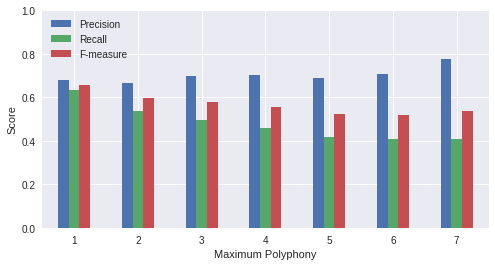

In [43]:
ax = df_poly.plot(kind='bar', x='poly',
                  rot=0, figsize=(8,4))
ax.set_xticklabels([int(x) for x in df_poly['poly']])
plt.ylabel('Score')
plt.xlabel('Maximum Polyphony')
plt.ylim([0.0, 1.0])
plt.show()

### include exp002 in the reuslts here?

In [102]:
results_bymaxpoly002 = []
for fl in file_list_bymaxpoly:
    if len(fl) > 0:
        r = ECR.evaluate_file_list('exp002', fl, load_predictions=True)
        results_bymaxpoly002.append(r)

F1s: 0.3497, P1s: 0.2313, R1s: 0.7166, F100ms: 0.3714, P100ms: 0.2518, R100ms: 0.7073 | E1s: 2.3931, E100ms: 2.1269
F1s: 0.4968, P1s: 0.4014, R1s: 0.6517, F100ms: 0.4900, P100ms: 0.4093, R100ms: 0.6103 | E1s: 1.0517, E100ms: 0.9869
F1s: 0.5139, P1s: 0.4620, R1s: 0.5788, F100ms: 0.4981, P100ms: 0.4621, R100ms: 0.5402 | E1s: 0.8120, E100ms: 0.8007
F1s: 0.5306, P1s: 0.5083, R1s: 0.5548, F100ms: 0.5033, P100ms: 0.4993, R100ms: 0.5073 | E1s: 0.7155, E100ms: 0.7284
F1s: 0.5011, P1s: 0.5030, R1s: 0.4991, F100ms: 0.4698, P100ms: 0.4870, R100ms: 0.4538 | E1s: 0.7250, E100ms: 0.7482
F1s: 0.4960, P1s: 0.5091, R1s: 0.4835, F100ms: 0.4658, P100ms: 0.5014, R100ms: 0.4349 | E1s: 0.7256, E100ms: 0.7312
F1s: 0.5158, P1s: 0.5213, R1s: 0.5104, F100ms: 0.4908, P100ms: 0.5179, R100ms: 0.4665 | E1s: 0.7292, E100ms: 0.7224


In [104]:
df_poly2 = pd.DataFrame(columns=['poly', 'Precision', 'Recall', 'F-measure'])
for poly in range(1, 8):
    f = results_bymaxpoly002[poly-1]['results1s']['overall']['f_measure']['f_measure']
    p = results_bymaxpoly002[poly-1]['results1s']['overall']['f_measure']['precision']
    r = results_bymaxpoly002[poly-1]['results1s']['overall']['f_measure']['recall']
    df_poly2.loc[len(df_poly2)] = [int(poly), p, r, f]

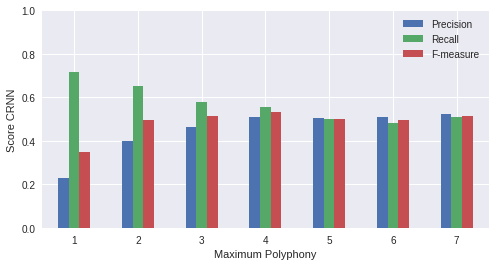

In [105]:
ax = df_poly2.plot(kind='bar', x='poly',
                   rot=0, figsize=(8,4))
ax.set_xticklabels([int(x) for x in df_poly2['poly']])
plt.ylabel('Score CRNN')
plt.xlabel('Maximum Polyphony')
plt.ylim([0.0, 1.0])
plt.show()

## ANALYZE PERFORMANCE BY GINI

In [44]:
results_bygini001 = []
for fl in file_list_bygini:
    if len(fl) > 0:
        r = E.evaluate_file_list('exp001', fl, load_predictions=True, large_cnn=False)
        results_bygini001.append(r)

F1s: 0.7515, P1s: 0.8267, R1s: 0.6889, F100ms: 0.7515, P100ms: 0.8267, R100ms: 0.6889 | E1s: 0.3667, E100ms: 0.3667
F1s: 0.6118, P1s: 0.6992, R1s: 0.5439, F100ms: 0.6118, P100ms: 0.6992, R100ms: 0.5439 | E1s: 0.5643, E100ms: 0.5643
F1s: 0.5892, P1s: 0.7013, R1s: 0.5080, F100ms: 0.5892, P100ms: 0.7013, R100ms: 0.5080 | E1s: 0.5720, E100ms: 0.5720
F1s: 0.5776, P1s: 0.6853, R1s: 0.4991, F100ms: 0.5776, P100ms: 0.6853, R100ms: 0.4991 | E1s: 0.5716, E100ms: 0.5716
F1s: 0.5591, P1s: 0.6957, R1s: 0.4673, F100ms: 0.5591, P100ms: 0.6957, R100ms: 0.4673 | E1s: 0.5882, E100ms: 0.5882
F1s: 0.5653, P1s: 0.6923, R1s: 0.4777, F100ms: 0.5653, P100ms: 0.6923, R100ms: 0.4777 | E1s: 0.5771, E100ms: 0.5771
F1s: 0.5734, P1s: 0.6879, R1s: 0.4916, F100ms: 0.5734, P100ms: 0.6879, R100ms: 0.4916 | E1s: 0.5714, E100ms: 0.5714
F1s: 0.5544, P1s: 0.6661, R1s: 0.4747, F100ms: 0.5544, P100ms: 0.6661, R100ms: 0.4747 | E1s: 0.5826, E100ms: 0.5826
F1s: 0.5965, P1s: 0.7351, R1s: 0.5018, F100ms: 0.5965, P100ms: 0.7351, R

In [45]:
df_gini = pd.DataFrame(columns=['Gini', 'Precision', 'Recall', 'F-measure'])
for gini in range(10):
    f = results_bygini001[gini]['results1s']['overall']['f_measure']['f_measure']
    p = results_bygini001[gini]['results1s']['overall']['f_measure']['precision']
    r = results_bygini001[gini]['results1s']['overall']['f_measure']['recall']
    df_gini.loc[len(df_gini)] = [gini/10.+0.1, p, r, f]

In [46]:
df_gini

,Gini,Precision,Recall,F-measure
0,0.1,0.826667,0.688889,0.751515
1,0.2,0.699248,0.543860,0.611842
2,0.3,0.701299,0.507996,0.589198
3,0.4,0.685347,0.499093,0.577576
4,0.5,0.695690,0.467287,0.559060
5,0.6,0.692322,0.477671,0.565306
6,0.7,0.687869,0.491553,0.573372
7,0.8,0.666135,0.474730,0.554377
8,0.9,0.735135,0.501845,0.596491
9,1.0,0.750000,0.800000,0.774194


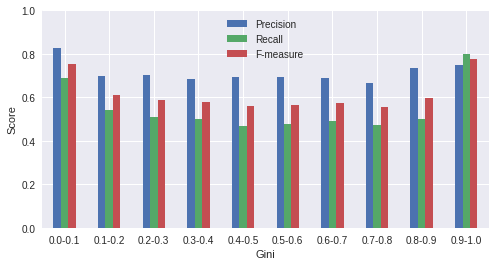

In [50]:
ax = df_gini.plot(kind='bar', x='Gini',
                  rot=0, figsize=(8,4))
ax.set_xticklabels(['{:.1f}-{:.1f}'.format(x-0.1, x) for x in df_gini['Gini']])
plt.ylabel('Score')
plt.xlabel('Gini')
plt.ylim([0.0, 1.0])
plt.show()

## ANALYZE PERFORMANCE BY N_EVENTS

In [51]:
results_bynevents001 = []
for fl in file_list_bynevents:
    if len(fl) > 0:
        r = E.evaluate_file_list('exp001', fl, load_predictions=True, large_cnn=False)
        results_bynevents001.append(r)

F1s: 0.6220, P1s: 0.6334, R1s: 0.6109, F100ms: 0.6220, P100ms: 0.6334, R100ms: 0.6109 | E1s: 0.5947, E100ms: 0.5947
F1s: 0.6304, P1s: 0.6680, R1s: 0.5968, F100ms: 0.6304, P100ms: 0.6680, R100ms: 0.5968 | E1s: 0.5544, E100ms: 0.5544
F1s: 0.6065, P1s: 0.6758, R1s: 0.5501, F100ms: 0.6065, P100ms: 0.6758, R100ms: 0.5501 | E1s: 0.5557, E100ms: 0.5557
F1s: 0.5955, P1s: 0.6926, R1s: 0.5223, F100ms: 0.5955, P100ms: 0.6926, R100ms: 0.5223 | E1s: 0.5457, E100ms: 0.5457
F1s: 0.5868, P1s: 0.7019, R1s: 0.5041, F100ms: 0.5868, P100ms: 0.7019, R100ms: 0.5041 | E1s: 0.5616, E100ms: 0.5616
F1s: 0.5713, P1s: 0.6804, R1s: 0.4923, F100ms: 0.5713, P100ms: 0.6804, R100ms: 0.4923 | E1s: 0.5664, E100ms: 0.5664
F1s: 0.5460, P1s: 0.6885, R1s: 0.4524, F100ms: 0.5460, P100ms: 0.6885, R100ms: 0.4524 | E1s: 0.5905, E100ms: 0.5905
F1s: 0.5535, P1s: 0.7079, R1s: 0.4543, F100ms: 0.5535, P100ms: 0.7079, R100ms: 0.4543 | E1s: 0.5862, E100ms: 0.5862
F1s: 0.5325, P1s: 0.7049, R1s: 0.4279, F100ms: 0.5325, P100ms: 0.7049, R

In [54]:
df_nevets = pd.DataFrame(columns=['n_events', 'Precision', 'Recall', 'F-measure'])
for nevents in range(1, 10):
    f = results_bynevents001[nevents-1]['results1s']['overall']['f_measure']['f_measure']
    p = results_bynevents001[nevents-1]['results1s']['overall']['f_measure']['precision']
    r = results_bynevents001[nevents-1]['results1s']['overall']['f_measure']['recall']
    df_nevets.loc[len(df_nevets)] = [int(nevents), p, r, f]

In [55]:
df_nevets

,n_events,Precision,Recall,F-measure
0,1.0,0.633436,0.610947,0.621988
1,2.0,0.668029,0.596786,0.630401
2,3.0,0.675751,0.550057,0.606460
3,4.0,0.692621,0.522256,0.595493
4,5.0,0.701851,0.504132,0.586784
5,6.0,0.680391,0.492330,0.571282
6,7.0,0.688471,0.452445,0.546044
7,8.0,0.707913,0.454336,0.553462
8,9.0,0.704862,0.427900,0.532522


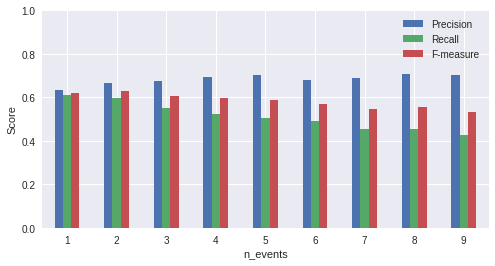

In [57]:
ax = df_nevets.plot(kind='bar', x='n_events', rot=0, figsize=(8,4))
ax.set_xticklabels([int(x) for x in df_nevets['n_events']])
plt.ylabel('Score')
plt.xlabel('n_events')
plt.ylim([0.0, 1.0])
plt.show()

## ANALYZE PERFORMANCE BY AVG SNR

In [72]:
results_byavgsnr001 = []
for fl in file_list_byavgsnr:
    if len(fl) > 0:
        r = E.evaluate_file_list('exp001', fl, load_predictions=True, large_cnn=False)
        results_byavgsnr001.append(r)

F1s: 0.5941, P1s: 0.6977, R1s: 0.5172, F100ms: 0.5941, P100ms: 0.6977, R100ms: 0.5172 | E1s: 0.5603, E100ms: 0.5603
F1s: 0.6000, P1s: 0.7500, R1s: 0.5000, F100ms: 0.6000, P100ms: 0.7500, R100ms: 0.5000 | E1s: 0.5498, E100ms: 0.5498
F1s: 0.5671, P1s: 0.7202, R1s: 0.4677, F100ms: 0.5671, P100ms: 0.7202, R100ms: 0.4677 | E1s: 0.5799, E100ms: 0.5799
F1s: 0.5565, P1s: 0.6988, R1s: 0.4623, F100ms: 0.5565, P100ms: 0.6988, R100ms: 0.4623 | E1s: 0.5859, E100ms: 0.5859
F1s: 0.5739, P1s: 0.6903, R1s: 0.4911, F100ms: 0.5739, P100ms: 0.6903, R100ms: 0.4911 | E1s: 0.5683, E100ms: 0.5683
F1s: 0.5778, P1s: 0.6590, R1s: 0.5144, F100ms: 0.5778, P100ms: 0.6590, R100ms: 0.5144 | E1s: 0.5736, E100ms: 0.5736
F1s: 0.5879, P1s: 0.6190, R1s: 0.5598, F100ms: 0.5879, P100ms: 0.6190, R100ms: 0.5598 | E1s: 0.5885, E100ms: 0.5885
F1s: 0.6400, P1s: 0.6061, R1s: 0.6780, F100ms: 0.6400, P100ms: 0.6061, R100ms: 0.6780 | E1s: 0.6441, E100ms: 0.6441


In [73]:
df_avgsnr = pd.DataFrame(columns=['avgsnr', 'Precision', 'Recall', 'F-measure'])
for avgsnr in range(8):
    f = results_byavgsnr001[avgsnr]['results1s']['overall']['f_measure']['f_measure']
    p = results_byavgsnr001[avgsnr]['results1s']['overall']['f_measure']['precision']
    r = results_byavgsnr001[avgsnr]['results1s']['overall']['f_measure']['recall']
    df_avgsnr.loc[len(df_avgsnr)] = [9 + avgsnr*3, p, r, f]

In [74]:
df_avgsnr

,avgsnr,Precision,Recall,F-measure
0,9.0,0.697674,0.517241,0.594059
1,12.0,0.750000,0.500000,0.600000
2,15.0,0.720158,0.467674,0.567083
3,18.0,0.698788,0.462292,0.556454
4,21.0,0.690268,0.491113,0.573904
5,24.0,0.659043,0.514380,0.577794
6,27.0,0.619048,0.559809,0.587940
7,30.0,0.606061,0.677966,0.640000


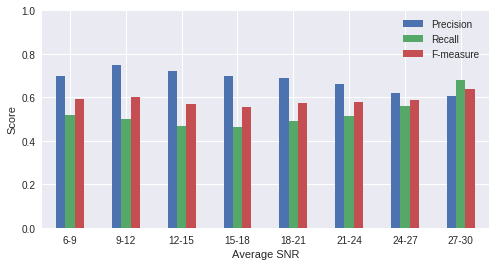

In [77]:
ax = df_avgsnr.plot(kind='bar', x='avgsnr', rot=0, figsize=(8,4))
ax.set_xticklabels(['{:d}-{:d}'.format(int(x-3), int(x)) for x in df_avgsnr['avgsnr']])
plt.ylabel('Score')
plt.xlabel('Average SNR')
plt.ylim([0.0, 1.0])
plt.show()

## ANALYZE PERFORMANCE BY AVG SNR (HALF THE BINS)

In [79]:
results_byavgsnrhalf001 = []
for fl in file_list_byavgsnr_half:
    if len(fl) > 0:
        r = E.evaluate_file_list('exp001', fl, load_predictions=True, large_cnn=False)
        results_byavgsnrhalf001.append(r)

F1s: 0.5991, P1s: 0.7412, R1s: 0.5026, F100ms: 0.5991, P100ms: 0.7412, R100ms: 0.5026 | E1s: 0.5515, E100ms: 0.5515
F1s: 0.5590, P1s: 0.7039, R1s: 0.4636, F100ms: 0.5590, P100ms: 0.7039, R100ms: 0.4636 | E1s: 0.5845, E100ms: 0.5845
F1s: 0.5749, P1s: 0.6820, R1s: 0.4969, F100ms: 0.5749, P100ms: 0.6820, R100ms: 0.4969 | E1s: 0.5696, E100ms: 0.5696
F1s: 0.5970, P1s: 0.6166, R1s: 0.5785, F100ms: 0.5970, P100ms: 0.6166, R100ms: 0.5785 | E1s: 0.5973, E100ms: 0.5973


In [80]:
df_avgsnr_half = pd.DataFrame(columns=['avgsnr', 'Precision', 'Recall', 'F-measure'])
for avgsnr in range(4):
    f = results_byavgsnrhalf001[avgsnr]['results1s']['overall']['f_measure']['f_measure']
    p = results_byavgsnrhalf001[avgsnr]['results1s']['overall']['f_measure']['precision']
    r = results_byavgsnrhalf001[avgsnr]['results1s']['overall']['f_measure']['recall']
    df_avgsnr_half.loc[len(df_avgsnr_half)] = [12 + avgsnr*6, p, r, f]

In [81]:
df_avgsnr_half

,avgsnr,Precision,Recall,F-measure
0,12.0,0.741245,0.502639,0.599057
1,18.0,0.703943,0.463608,0.559040
2,24.0,0.681972,0.496884,0.574898
3,30.0,0.616595,0.578523,0.596953


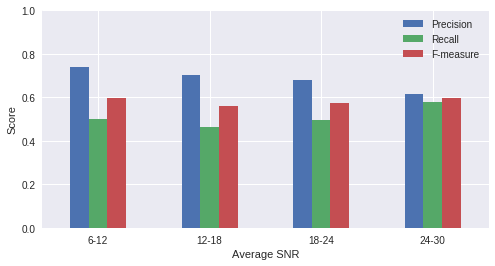

In [82]:
ax = df_avgsnr_half.plot(kind='bar', x='avgsnr', rot=0, figsize=(8,4))
ax.set_xticklabels(['{:d}-{:d}'.format(int(x-6), int(x)) for x in df_avgsnr_half['avgsnr']])
plt.ylabel('Score')
plt.xlabel('Average SNR')
plt.ylim([0.0, 1.0])
plt.show()

# BASIC STATS FOR COMPLETE DATASET

## train

In [97]:
metafolder_train = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/metadata/train/'
feature_folder_train = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/features/logmelspec1764_128/train/'
file_list_train = sorted(glob.glob(os.path.join(feature_folder_train, '*.npy.gz')))
file_list_train = [os.path.basename(x).replace('.npy.gz', '') for x in file_list_train]

In [98]:
train_vals_maxpoly = []
train_vals_nevents = []
train_vals_gini = []
train_vals_avg_snr = []
train_vals_fg_events = ({'event_duration': [],
                  'event_time': [],
                  'label': [],
                  'pitch_shift': [],
                  'snr': [],
                  'time_stretch': []})

event_properties = ['event_duration', 'event_time', 'label', 'pitch_shift', 'snr', 'time_stretch']

for filename in tqdm(file_list_train):

    jamfile = os.path.join(metafolder_train, filename + '.jams')
    jam = jams.load(jamfile)
                 
    train_vals_maxpoly.append(jam.annotations[0].sandbox['scaper']['polyphony_max'])
    train_vals_nevents.append(jam.annotations[0].sandbox['scaper']['n_events'])
    train_vals_gini.append(jam.annotations[0].sandbox['scaper']['polyphony_gini'])
    
    snrs = []
    for event in jam.annotations[0].data['value']:
        if event['role'] == 'foreground':
            for prop in event_properties:
                train_vals_fg_events[prop].append(event[prop])
                
            snrs.append(event['snr'])
    train_vals_avg_snr.append(np.mean(snrs))


100%|██████████| 6000/6000 [03:41<00:00, 32.07it/s]


In [99]:
# How many events total?
len(train_vals_fg_events['label'])

29919

In [100]:
# How many events of each class?
train_df_label = pd.DataFrame(train_vals_fg_events['label'])
train_df_label[0].value_counts()

dog_bark            3055
gun_shot            3035
drilling            3013
jackhammer          3013
street_music        3001
engine_idling       2989
air_conditioner     2982
siren               2949
children_playing    2941
car_horn            2941
Name: 0, dtype: int64

## validate

In [106]:
metafolder_val = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/metadata/validate/'
feature_folder_val = '/scratch/js7561/datasets/scaper_waspaa2017/urban-sed/features/logmelspec1764_128/validate/'
file_list_val = sorted(glob.glob(os.path.join(feature_folder_val, '*.npy.gz')))
file_list_val = [os.path.basename(x).replace('.npy.gz', '') for x in file_list_val]

In [107]:
len(file_list_val)

2000

In [109]:
val_vals_maxpoly = []
val_vals_nevents = []
val_vals_gini = []
val_vals_avg_snr = []
val_vals_fg_events = ({'event_duration': [],
                  'event_time': [],
                  'label': [],
                  'pitch_shift': [],
                  'snr': [],
                  'time_stretch': []})

event_properties = ['event_duration', 'event_time', 'label', 'pitch_shift', 'snr', 'time_stretch']

for filename in tqdm(file_list_val):

    jamfile = os.path.join(metafolder_val, filename + '.jams')
    jam = jams.load(jamfile)
                 
    val_vals_maxpoly.append(jam.annotations[0].sandbox['scaper']['polyphony_max'])
    val_vals_nevents.append(jam.annotations[0].sandbox['scaper']['n_events'])
    val_vals_gini.append(jam.annotations[0].sandbox['scaper']['polyphony_gini'])
    
    snrs = []
    for event in jam.annotations[0].data['value']:
        if event['role'] == 'foreground':
            for prop in event_properties:
                val_vals_fg_events[prop].append(event[prop])
                
            snrs.append(event['snr'])
    val_vals_avg_snr.append(np.mean(snrs))

100%|██████████| 2000/2000 [01:08<00:00, 29.11it/s]


In [110]:
# How many events total?
len(val_vals_fg_events['label'])

9956

In [111]:
# How many events of each class?
val_df_label = pd.DataFrame(val_vals_fg_events['label'])
val_df_label[0].value_counts()

air_conditioner     1059
dog_bark            1028
street_music        1026
drilling            1014
engine_idling       1006
children_playing     986
gun_shot             982
siren                967
jackhammer           947
car_horn             941
Name: 0, dtype: int64

### GINI reminder (0 = unequal, 1 = equal, designed to mimic entropy)

In [66]:
def compute_gini(series):
    series = np.asarray(series, dtype='float')
    series += 1e-6  # all values must be positive
    values = np.sort(series)  # sort values
    n = len(values)
    i = np.arange(n) + 1
    gini = np.sum((2*i - n - 1) * values) / (n * np.sum(values))
    return (1 - gini)

In [67]:
compute_gini(np.arange(0, 10, 1.0))

0.63333341481479666

In [68]:
compute_gini(np.ones(10))

1.0

In [71]:
compute_gini([1, 1, 1, 1, 800, 1, 1, 1, 1, 1, 1])

0.10325478209945793